In [1]:
import numpy as np
import os
import six
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from PIL import Image

import pandas as pd
import pickle

import sys
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util

In [2]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def encode_image_array_as_jpg_str(image):
    """Encodes a numpy array into a JPEG string.
    Args:
    image: a numpy array with shape [height, width, 3].
    Returns:
    JPEG encoded image string.
    """
    image_pil = Image.fromarray(np.uint8(image))
    output = six.BytesIO()
    image_pil.save(output, format='JPEG')
    jpg_string = output.getvalue()
    output.close()
    
    return jpg_string

def create_record(row): 
    height = row['height']
    width = row['width']
    filename = row['filename'].encode()

    image = Image.open(os.path.join('images', row['filename']))
    image_np = load_image_into_numpy_array(image)
    encoded_image_data = encode_image_array_as_jpg_str(image_np)
    
    assert (height, width, 3) == image_np.shape, "Image not found or wrong shape!"

    image_format = b'jpeg'
    xmins = [ float(i) for i in row['xmins'] ] 
    xmaxs = [ float(i) for i in row['xmaxs'] ]
    ymins = [ float(i) for i in row['ymins'] ]
    ymaxs = [ float(i) for i in row['ymaxs'] ]
    classes_text = [ i for i in row['classes_text'] ] 
    classes = [ int(i) for i in row['classes'] ]

    tf_record = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
        
    return tf_record

### Creates train and test `tf.record`

In [3]:
for pickleFile in ['train.p', 'test.p']: 
    
    with open(os.path.join('data', pickleFile), 'rb') as f:
        df = pickle.load(f)
    
    recordFile = (pickleFile[:-2]+'.record').encode()
    
    print("Writing {} ...".format(recordFile))
    
    writer = tf.python_io.TFRecordWriter(recordFile)

    for i in range(df.shape[0]):

        row = df.iloc[i, ]        
        record = create_record(row)
        writer.write(record.SerializeToString())

    writer.close()
    
    print("Finished writing {}.".format(recordFile))

Writing b'train.record' ...
Finished writing b'train.record'.
Writing b'test.record' ...
Finished writing b'test.record'.


### Creates a mini `tf.record` for Proof-of-Concept

In [4]:
with open(os.path.join('data', 'train.p'), 'rb') as f:
    train = pickle.load(f)
        
mini = train.iloc[:2, ]

mini.head()

,filename,xmins,xmaxs,ymins,ymaxs,classes,classes_text,height,width,class_text
163,site_1507478178.229204893.png,[0.467687249184],[0.495300710201],[0.344213575125],[0.453657537699],[3],[b'green'],1096,1368,b'green'
28,sim_1507476784.png,"[0.59875, 0.66375, 0.72875]","[0.6175, 0.6775, 0.74]","[0.958333333333, 0.956666666667, 0.963333333333]","[0.998333333333, 0.998333333333, 0.998333333333]","[3, 3, 3]","[b'green', b'green', b'green']",600,800,b'green'


In [5]:
print("Writing mini.record ...")

writer = tf.python_io.TFRecordWriter(b'mini.record')

for i in range(mini.shape[0]):

    row = mini.iloc[i, ]
    record = create_record(row)
    writer.write(record.SerializeToString())

writer.close()

print("Finished writing mini.record.")

Writing mini.record ...
Finished writing mini.record.


### Eyeballing the image, its xmins, xmaxs, ymins, ymaxs

In [6]:
image1 = Image.open(os.path.join('images', mini.iloc[0,0]))
image2 = Image.open(os.path.join('images', mini.iloc[1,0]))

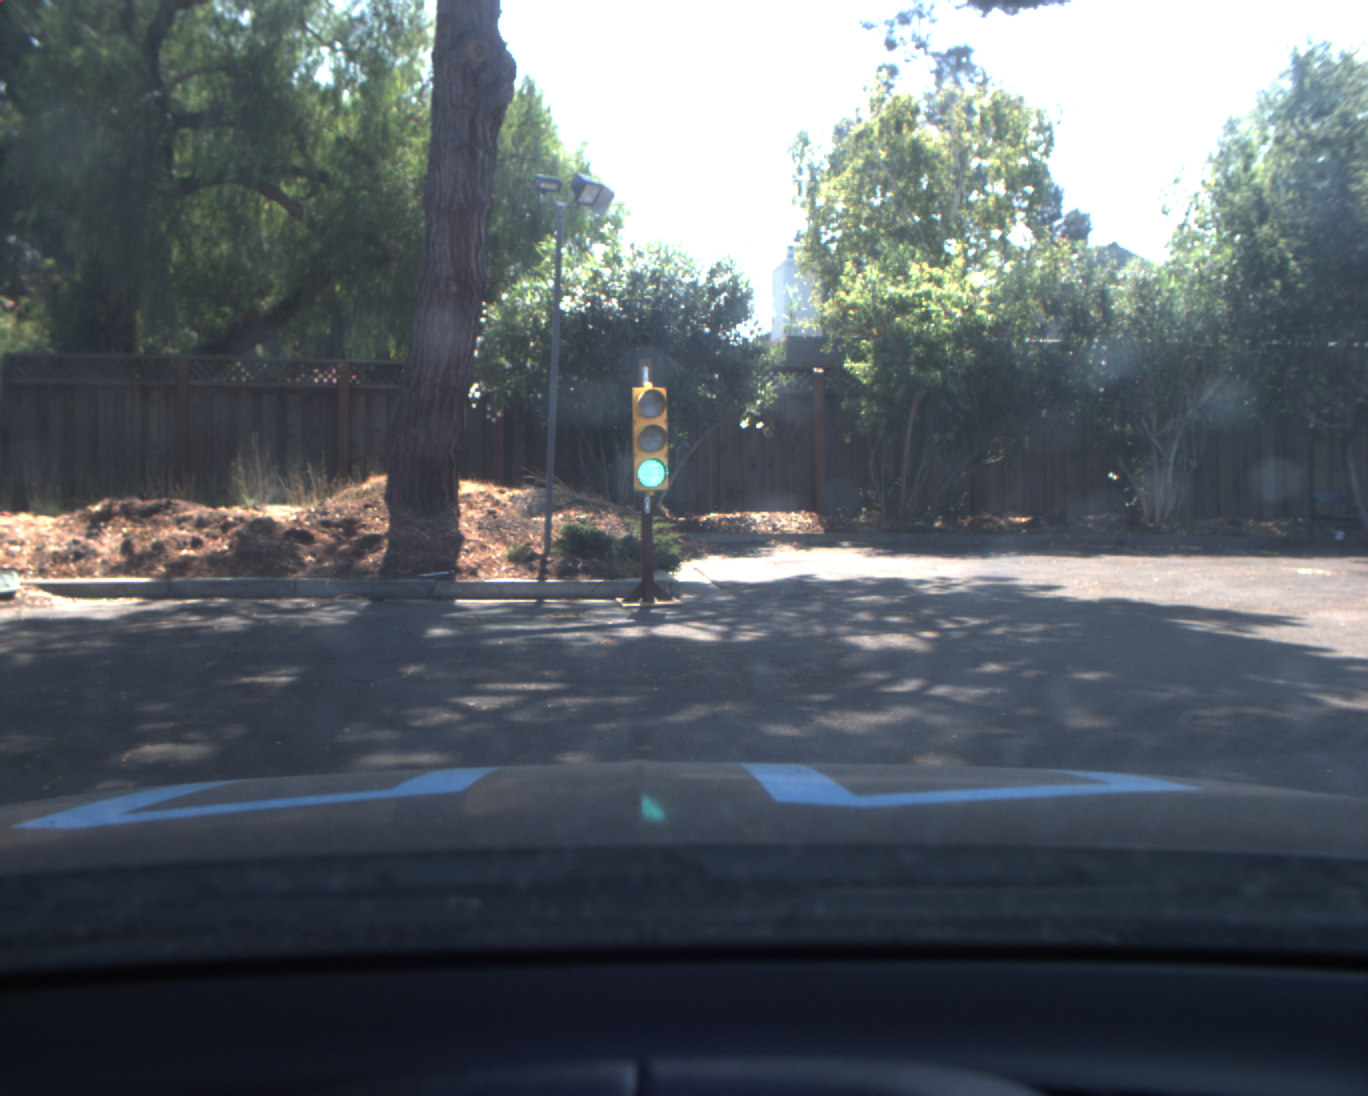

In [7]:
image1

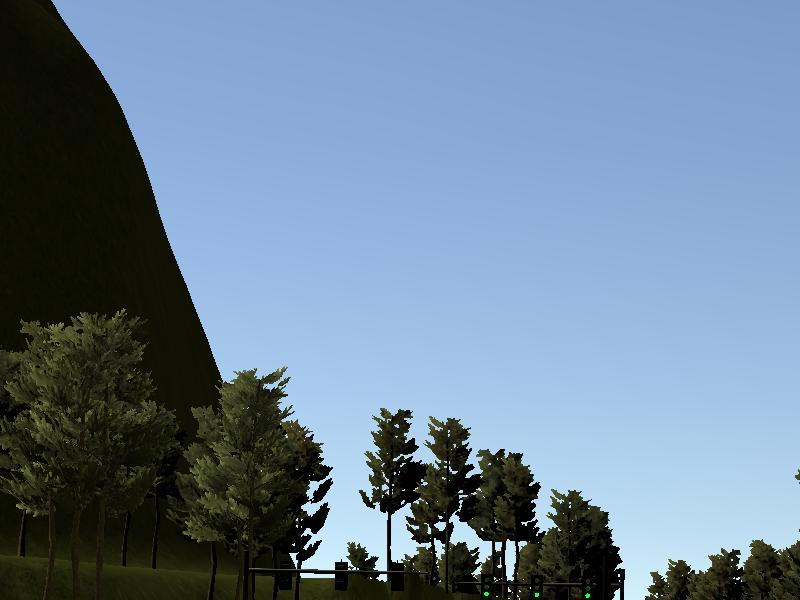

In [8]:
image2